# KerasDNNモデルの作成


**学習目標**

1.生のフィーチャの入力レイヤーを作成します
1.入力用のフィーチャ列を作成します
1.DNN高密度隠しレイヤーと出力レイヤーを作成します
1.すべてのピースを結び付けるDNNモデルを構築します
1.トレーニングと評価


## 序章
このノートブックでは、Kerasを使用してDNNモデルを作成し、赤ちゃんが生まれる前の体重を予測します。

まず、データ入力のCSV列名、ラベル列、および列のデフォルトを定義します。次に、CSVファイルからフィーチャとラベルのtf.dataデータセットを構築し、生のフィーチャの入力レイヤーを作成します。次に、モデル入力の特徴列を設定し、Kerasでディープニューラルネットワークを構築します。カスタム評価メトリックを作成し、DNNモデルを構築します。最後に、モデルをトレーニングして評価します。

各学習目標は、[学生ラボノートブック]（https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/machine_learning/deepdive2/end_to_end_ml/labs/keras_dnn_babyweight）の__＃TODO__に対応します。 ipynb）-このソリューションノートブックを確認する前に、まずそのノートブックを完成させてください。

## 環境変数を設定し、必要なライブラリをロードします

In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [2]:
!pip install --user google-cloud-bigquery==1.25.0

     |████████████████████████████████| 169 kB 8.7 MB/s            
     |████████████████████████████████| 93 kB 2.0 MB/s             
     |████████████████████████████████| 152 kB 44.6 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
google-cloud-storage 1.43.0 requires google-resumable-media<3.0dev,>=1.3.0; python_version >= "3.6", but you have google-resumable-media 0.5.1 which is incompatible.
cloud-tpu-client 0.10 requires google-api-python-client==1.8.0, but you have google-api-python-client 2.31.0 which is incompatible.


**注**：更新されたパッケージを使用するには、カーネルを再起動してください。

google-cloud-storageに関連する非推奨の警告と非互換性エラーは無視してください。

必要なライブラリをインポートします。

In [3]:
from google.cloud import bigquery
import pandas as pd
import datetime
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.3.4


ノートブック全体で使用できるように環境変数を設定します。Set environment variables so that we can use them throughout the notebook.

In [4]:
%%bash
export PROJECT=$(gcloud config list project --format "value(core.project)")
echo "Your current GCP Project Name is: "$PROJECT

Your current GCP Project Name is: qwiklabs-gcp-02-0c32efa33ea3


In [5]:
PROJECT = "qwiklabs-gcp-02-0c32efa33ea3"  # Replace with your PROJECT

## BigQueryを使用してサンプリングしてMLデータセットを作成する

まず、BigQueryデータをサンプリングして、より小さなデータセットを作成します。ラボ全体で使用するBigQueryクライアントを作成しましょう

In [6]:
bq = bigquery.Client(project = PROJECT)

ハッシュ値を分割して目的の分割を取得する正しい方法を理解する必要があります。これを行うには、モジュール内でハッシュするいくつかの値を定義する必要があります。完璧な組み合わせを得るために、これらの値を自由に試してみてください。

In [7]:
modulo_divisor = 100
train_percent = 80.0
eval_percent = 10.0

train_buckets = int(modulo_divisor * train_percent / 100.0)
eval_buckets = int(modulo_divisor * eval_percent / 100.0)

一連のクエリを実行して、バケット値が各データセット分割の正しいサイズになるかどうかを確認し、それに応じて調整することができます。したがって、コードをよりコンパクトで再利用できるようにするために、クエリから生成されたデータフレームの先頭を特定の行数まで返す関数を定義しましょう。

In [8]:
def display_dataframe_head_from_query(query, count=10):
    """Displays count rows from dataframe head from query.
    
    Args:
        クエリ：str、BigQueryで実行されるクエリ、結果はデータフレームに保存されます。
        count：int、データフレームの先頭から表示する結果の数。
    Returns:
        Dataframe head with count number of results.
    """
    df = bq.query(
        query + " LIMIT {limit}".format(
            limit=count)).to_dataframe()

    return df.head(count)

最初のクエリでは、上記の元のクエリを使用して、ラベル、機能、列をハッシュに結合し、繰り返し可能な分割を実行します。データセットには、限られた数の年、月、日、および状態しかありません。ハッシュ値が何であるかを見てみましょう。データをかなり均一に分散させるには、ハッシュするためにこれらの追加の列をすべて含める必要があります。ハッシュを少しずつ試してみて、結果がどのように変化するかを確認してください

In [9]:
# ラベル、機能、列を取得してハッシュし、バケットに分割します
hash_cols_fixed_query = """
SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks,
    year,
    month,
    CASE
        WHEN day IS NULL THEN
            CASE
                WHEN wday IS NULL THEN 0
                ELSE wday
            END
        ELSE day
    END AS date,
    IFNULL(state, "Unknown") AS state,
    IFNULL(mother_birth_state, "Unknown") AS mother_birth_state
FROM
    publicdata.samples.natality
WHERE
    year > 2000
    AND weight_pounds > 0
    AND mother_age > 0
    AND plurality > 0
    AND gestation_weeks > 0
"""

display_dataframe_head_from_query(hash_cols_fixed_query)

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,year,month,date,state,mother_birth_state
0,7.063611,True,32,1,37,2001,12,3,CO,CA
1,4.687028,True,30,3,33,2001,6,5,IN,IN
2,7.561856,True,20,1,39,2001,4,5,MN,MN
3,7.561856,True,31,1,37,2001,10,5,MS,MS
4,7.312733,True,32,1,40,2001,11,3,MO,MO
5,7.627994,False,30,1,40,2001,10,5,NY,PA
6,7.251004,True,33,1,37,2001,11,5,WA,WA
7,7.500126,False,23,1,39,2001,9,2,OK,LA
8,7.125340,False,33,1,39,2001,1,4,TX,MS
9,7.749249,True,31,1,39,2001,1,1,TX,Foreign


`COALESCE`を使用すると、ネストされた` CASEWHEN`と同じ結果が得られます。これは、必要なのが最初のnull以外のインスタンスだけである場合に適しています。正確には、「CASEWHEN」は「COALESCE（wday、day、0）ASdate」になります。詳細については、[こちら]（https://cloud.google.com/bigquery/docs/reference/standard-sql/conditional_expressions）をご覧ください。

次のクエリでは、ハッシュ列が結合され、ラベル、機能、およびハッシュ値だけが残ります。

In [10]:
data_query = """
SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks,
    FARM_FINGERPRINT(
        CONCAT(
            CAST(year AS STRING),
            CAST(month AS STRING),
            CAST(date AS STRING),
            CAST(state AS STRING),
            CAST(mother_birth_state AS STRING)
        )
    ) AS hash_values
FROM
    ({CTE_hash_cols_fixed})
""".format(CTE_hash_cols_fixed=hash_cols_fixed_query)

display_dataframe_head_from_query(data_query)

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hash_values
0,6.062712,True,32,1,37,-2153513044363534592
1,6.999677,False,32,1,39,-4430124922453321990
2,7.874912,True,18,1,39,-1311908950195892989
3,7.936641,False,45,1,38,-6360108873637544251
4,2.561771,True,33,2,34,8927462325803958019
5,6.060508,False,29,1,39,-4890586978434375847
6,7.687519,False,33,1,38,1243255502702899369
7,6.812284,False,40,1,37,-4649571928108924003
8,6.750554,True,33,1,39,5980521934993007910
9,5.136771,True,27,1,33,-3063463760527576993


次のクエリでは、一意の657484`hash_values`のそれぞれのカウントを検索します。これは、 `GROUPBY`を介して分割用の実際のハッシュバケットを作成するための最初のステップになります。

In [13]:
# 分割列の一意のハッシュのそれぞれのカウントを取得します
first_bucketing_query = """
SELECT
    hash_values,
    COUNT(*) AS num_records
FROM
    ({CTE_data})
GROUP BY
    hash_values
""".format(CTE_data=data_query)

display_dataframe_head_from_query(first_bucketing_query)

,hash_values,num_records
0,-4693523204227821573,40
1,-2041930022921169724,1
2,-6190130997840283969,1320
3,-5127176934561882897,39
4,-1888248553071786964,576
5,-5899606308232716406,1562
6,-4694257942846950625,439
7,-2885485386411533513,1754
8,3820521621488099714,1511
9,8730041800929392116,444


以下のクエリは、バケット化の2番目のレイヤーを実行します。ここで、これらのバケットインデックスのそれぞれについて、レコードの数をカウントします。

In [14]:
# 各ハッシュバケットのレコード数を取得します
second_bucketing_query = """
SELECT
    ABS(MOD(hash_values, {modulo_divisor})) AS bucket_index,
    SUM(num_records) AS num_records
FROM
    ({CTE_first_bucketing})
GROUP BY
    ABS(MOD(hash_values, {modulo_divisor}))
""".format(
    CTE_first_bucketing=first_bucketing_query, modulo_divisor=modulo_divisor)

display_dataframe_head_from_query(second_bucketing_query)

,bucket_index,num_records
0,98,374697
1,1,163893
2,57,453019
3,97,480790
4,68,197797
5,51,180001
6,17,222562
7,38,338150
8,29,453175
9,39,224255


レコードの数は分割を簡単に理解するのが難しいため、次のクエリで各ハッシュバケットのデータのパーセンテージにカウントを正規化します。

In [15]:
# Calculate the overall percentages
percentages_query = """
SELECT
    bucket_index,
    num_records,
    CAST(num_records AS FLOAT64) / (
    SELECT
        SUM(num_records)
    FROM
        ({CTE_second_bucketing})) AS percent_records
FROM
    ({CTE_second_bucketing})
""".format(CTE_second_bucketing=second_bucketing_query)

display_dataframe_head_from_query(percentages_query)

,bucket_index,num_records,percent_records
0,5,449280,0.013610
1,12,412875,0.012507
2,40,333712,0.010109
3,84,341155,0.010334
4,94,431001,0.013056
5,56,226752,0.006869
6,50,184434,0.005587
7,88,423809,0.012838
8,28,449682,0.013622
9,26,492824,0.014929


次に、トレーニングで使用するバケットの範囲を選択します。

In [16]:
# トレーニング用のハッシュバケットを選択し、それらの統計を取得します
train_query = """
SELECT
    *,
    "train" AS dataset_name
FROM
    ({CTE_percentages})
WHERE
    bucket_index >= 0
    AND bucket_index < {train_buckets}
""".format(
    CTE_percentages=percentages_query,
    train_buckets=train_buckets)

display_dataframe_head_from_query(train_query)

,bucket_index,num_records,percent_records,dataset_name
0,52,204972,0.006209,train
1,33,410226,0.012427,train
2,79,403701,0.012229,train
3,65,289303,0.008764,train
4,75,367455,0.011131,train
5,47,393747,0.011928,train
6,59,361078,0.010938,train
7,41,244850,0.007417,train
8,0,277395,0.008403,train
9,11,204557,0.006197,train


評価に使用するバケットの範囲を選択して、同じことを行います。

In [17]:
# 検証用のハッシュバケットを選択し、それらの統計を取得します
eval_query = """
SELECT
    *,
    "eval" AS dataset_name
FROM
    ({CTE_percentages})
WHERE
    bucket_index >= {train_buckets}
    AND bucket_index < {cum_eval_buckets}
""".format(
    CTE_percentages=percentages_query,
    train_buckets=train_buckets,
    cum_eval_buckets=train_buckets + eval_buckets)

display_dataframe_head_from_query(eval_query)

,bucket_index,num_records,percent_records,dataset_name
0,83,411258,0.012458,eval
1,89,256482,0.007770,eval
2,88,423809,0.012838,eval
3,84,341155,0.010334,eval
4,82,468179,0.014182,eval
5,85,368045,0.011149,eval
6,87,523881,0.015870,eval
7,80,312489,0.009466,eval
8,86,274489,0.008315,eval
9,81,233538,0.007074,eval


最後に、テスト分割に使用するハッシュバケットを選択します。

In [18]:
# テスト用のハッシュバケットを選択し、それらの統計を取得します
test_query = """
SELECT
    *,
    "test" AS dataset_name
FROM
    ({CTE_percentages})
WHERE
    bucket_index >= {cum_eval_buckets}
    AND bucket_index < {modulo_divisor}
""".format(
    CTE_percentages=percentages_query,
    cum_eval_buckets=train_buckets + eval_buckets,
    modulo_divisor=modulo_divisor)

display_dataframe_head_from_query(test_query)

,bucket_index,num_records,percent_records,dataset_name
0,93,215710,0.006534,test
1,90,286465,0.008678,test
2,99,223334,0.006765,test
3,92,336735,0.010201,test
4,95,313544,0.009498,test
5,96,529357,0.016036,test
6,94,431001,0.013056,test
7,97,480790,0.014564,test
8,91,333267,0.010096,test
9,98,374697,0.011351,test


以下のクエリでは、ハッシュバケットの3つのセットすべてが1つのテーブル内に収まるように、すべてのデータセットを「UNIONALL」します。後でクエリで並べ替えられるように、 `dataset_id`を追加しました。

In [ ]:
#データセット統計のトレーニング、検証、テストを統合する
union_query = """
SELECT
    0 AS dataset_id,
    *
FROM
    ({CTE_train})
UNION ALL
SELECT
    1 AS dataset_id,
    *
FROM
    ({CTE_eval})
UNION ALL
SELECT
    2 AS dataset_id,
    *
FROM
    ({CTE_test})
""".format(CTE_train=train_query, CTE_eval=eval_query, CTE_test=test_query)

display_dataframe_head_from_query(union_query)

,dataset_id,bucket_index,num_records,percent_records,dataset_name
0,0,28,449682,0.013622,train
1,0,12,412875,0.012507,train
2,0,50,184434,0.005587,train
3,0,5,449280,0.013610,train
4,0,26,492824,0.014929,train
5,0,56,226752,0.006869,train
6,0,40,333712,0.010109,train
7,0,42,405587,0.012286,train
8,0,37,295153,0.008941,train
9,0,24,352559,0.010680,train


最後に、train、eval、およびtestセット間の最終的な分割を示します。レコード数と全データの割合の両方を確認できます。それは私たちが手に入れたいと思っていたものに本当に近いです。

In [20]:
# 最終分割と関連する統計を表示する
split_query = """
SELECT
    dataset_id,
    dataset_name,
    SUM(num_records) AS num_records,
    SUM(percent_records) AS percent_records
FROM
    ({CTE_union})
GROUP BY
    dataset_id,
    dataset_name
ORDER BY
    dataset_id
""".format(CTE_union=union_query)

display_dataframe_head_from_query(split_query)

,dataset_id,dataset_name,num_records,percent_records
0,0,train,25873134,0.783765
1,1,eval,3613325,0.109457
2,2,test,3524900,0.106778


分割値がデータに適切なグローバル分割を生成することがわかったので、train、eval、testセットが重複せず、次のサブサンプルを取得するように、データの適切に分散された部分を取得する方法を次に示します。私たちのグローバルスプリット。

In [22]:
# every_nを使用すると、各ハッシュ値からサブサンプリングできます
# これにより、必要なレコード数を概算できます
every_n = 1000

splitting_string = "ABS(MOD(hash_values, {0} * {1}))".format(every_n, modulo_divisor)

def create_data_split_sample_df(query_string, splitting_string, lo, up):
    """Creates a dataframe with a sample of a data split.

    Args:
        query_string：str、分割を生成するために実行するクエリ。
        splitting_string：str、分割するモジュロ文字列。
        lo：float、分割のバケットフィルタリングの下限。
        up：float、分割のバケットフィルタリングの上限。
    Returns:
        データ分割サンプルを含むデータフレーム。
    """
    query = "SELECT * FROM ({0}) WHERE {1} >= {2} and {1} < {3}".format(
        query_string, splitting_string, int(lo), int(up))

    df = bq.query(query).to_dataframe()

    return df

train_df = create_data_split_sample_df(
    data_query, splitting_string,
    lo=0, up=train_percent)

eval_df = create_data_split_sample_df(
    data_query, splitting_string,
    lo=train_percent, up=train_percent + eval_percent)

test_df = create_data_split_sample_df(
    data_query, splitting_string,
    lo=train_percent + eval_percent, up=modulo_divisor)

print("There are {} examples in the train dataset.".format(len(train_df)))
print("There are {} examples in the validation dataset.".format(len(eval_df)))
print("There are {} examples in the test dataset.".format(len(test_df)))

There are 7733 examples in the train dataset.
There are 1037 examples in the validation dataset.
There are 561 examples in the test dataset.


## パンダを使用してデータを前処理する

データセット内のデータに対していくつかの前処理ステップを実行します。超音波の欠如をシミュレートするために行を追加してみましょう。つまり、いくつかの行を複製し、 `is_male`フィールドを` Unknown`にします。また、子が複数ある場合は、 `plurality`を` Multiple（2+） `に変更します。その間に、複数の列を文字列に変更します。これらの操作は以下で実行します。

トレーニングデータセットをそのまま調べることから始めましょう。

In [23]:
train_df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hash_values
0,5.937049,True,23,1,39,-6784884401981100070
1,7.374463,True,28,1,38,-1792211462198300014
2,7.810978,True,22,1,42,-2473233337125700055
3,8.999270,True,21,1,38,6567453535821100019
4,6.250105,True,19,1,37,4896699230184800022


また、一部の行で欠落している非常に重要な数値フィールドがいくつかあることに注意してください（Pandasでのカウントでは、欠落しているデータはカウントされません）

In [24]:
train_df.describe()

,weight_pounds,mother_age,plurality,gestation_weeks,hash_values
count,7733.000000,7733.000000,7733.000000,7733.000000,7.733000e+03
mean,7.264415,28.213371,1.035691,38.691064,-2.984870e+17
std,1.303220,6.134232,0.201568,2.531921,5.590715e+18
min,0.562179,13.000000,1.000000,18.000000,-9.210618e+18
25%,6.624891,23.000000,1.000000,38.000000,-6.781866e+18
50%,7.345803,28.000000,1.000000,39.000000,5.057323e+17
75%,8.062305,33.000000,1.000000,40.000000,4.896699e+18
max,11.563246,48.000000,4.000000,47.000000,9.203641e+18


機械学習で使用する前に生データをクリーンアップすることが常に重要であるため、前処理ステップがあります。以下に「前処理」関数を定義します。母親の年齢はモデルへの入力であるため、ユーザーは母親の年齢を提供する必要があることに注意してください。そうしないと、サービスが機能しません。モデルに使用する機能は、非常に優れた予測子であり、収集が簡単であるために選択されました。

In [26]:
def preprocess(df):
    """ Preprocess pandas dataframe for augmented babyweight data.
    
    Args:
        df: Dataframe containing raw babyweight data.
    Returns:
        Pandas dataframe containing preprocessed raw babyweight data as well
            as simulated no ultrasound data masking some of the original data.
    """
    # 生データをクリーンアップする
    # トレーニングに使用したくないものを除外する
    df = df[df.weight_pounds > 0]
    df = df[df.mother_age > 0]
    df = df[df.gestation_weeks > 0]
    df = df[df.plurality > 0]

    # 複数のフィールドを文字列に変更する
    twins_etc = dict(zip([1,2,3,4,5],
                   ["Single(1)",
                    "Twins(2)",
                    "Triplets(3)",
                    "Quadruplets(4)",
                    "Quintuplets(5)"]))
    df["plurality"].replace(twins_etc, inplace=True)

    # データのクローンを作成し、特定の列をマスクして、超音波の欠如をシミュレートします
    no_ultrasound = df.copy(deep=True)

    # is_maleを変更する
    no_ultrasound["is_male"] = "Unknown"
    
    # 複数を変更する
    condition = no_ultrasound["plurality"] != "Single(1)"
    no_ultrasound.loc[condition, "plurality"] = "Multiple(2+)"

    # 両方のデータセットを連結してシャッフルします
    return pd.concat(
        [df, no_ultrasound]).sample(frac=1).reset_index(drop=True)

トレーニング、評価、テストセットを処理し、前処理後にトレーニングデータの小さなサンプルを見てみましょう。

In [27]:
train_df = preprocess(train_df)
eval_df = preprocess(eval_df)
test_df = preprocess(test_df)

In [28]:
train_df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hash_values
0,7.687519,Unknown,28,Single(1),38,-8754700830739600051
1,6.876218,Unknown,44,Single(1),40,3835474516102300019
2,8.836127,Unknown,35,Single(1),40,8600166249228700063
3,7.125340,True,36,Single(1),39,-6604414550494400011
4,11.001067,Unknown,43,Single(1),39,925242206604100021


In [29]:
train_df.tail()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hash_values
15461,6.499227,Unknown,22,Single(1),39,4767958224853300002
15462,5.626197,False,22,Single(1),39,-3721975748227700022
15463,7.438397,Unknown,17,Single(1),38,4896699230184800022
15464,8.531890,Unknown,19,Single(1),39,-2651993754446100056
15465,5.875319,True,15,Single(1),36,4896699230184800022


データセットの概要をもう一度見てみましょう。数値列のみが表示されるため、 `plurality`は表示されないことに注意してください。

In [30]:
train_df.describe()

,weight_pounds,mother_age,gestation_weeks,hash_values
count,15466.000000,15466.000000,15466.000000,1.546600e+04
mean,7.264415,28.213371,38.691064,-2.984870e+17
std,1.303178,6.134034,2.531839,5.590534e+18
min,0.562179,13.000000,18.000000,-9.210618e+18
25%,6.624891,23.000000,38.000000,-6.781866e+18
50%,7.345803,28.000000,39.000000,5.057323e+17
75%,8.062305,33.000000,40.000000,4.896699e+18
max,11.563246,48.000000,47.000000,9.203641e+18


## .csvファイルに書き込む

最終バージョンでは、Pandasデータフレームではなくファイルから読み取りたいと考えています。そのため、Pandasデータフレームをcsvファイルとして書き出します。 csvファイルを使用すると、読み取り中にシャッフルできるという利点があります。一部のワーカーは他のワーカーよりも遅い可能性があるため、これは分散トレーニングにとって重要です。データをシャッフルすると、同じデータが遅いワーカーに割り当てられるのを防ぐのに役立ちます。

In [32]:
# 列を定義する
columns = ["weight_pounds",
           "is_male",
           "mother_age",
           "plurality",
           "gestation_weeks"]

# CSVファイルを書き出す
train_df.to_csv(
    path_or_buf="train.csv", columns=columns, header=False, index=False)
eval_df.to_csv(
    path_or_buf="eval.csv", columns=columns, header=False, index=False)
test_df.to_csv(
    path_or_buf="test.csv", columns=columns, header=False, index=False)

In [33]:
%%bash
wc -l *.csv

  2074 eval.csv
  1122 test.csv
 15466 train.csv
 18662 total


In [34]:
%%bash
head *.csv

==> eval.csv <==
7.936641432,Unknown,36,Single(1),38
5.8753192823,False,38,Single(1),39
7.7492485093,Unknown,33,Single(1),40
6.6469371993,Unknown,39,Single(1),38
7.71617917,False,21,Single(1),38
10.12583169366,True,33,Single(1),43
6.4992274837599995,Unknown,36,Single(1),40
7.81318256528,False,30,Single(1),38
7.7492485093,Unknown,21,Single(1),38
7.12534030784,Unknown,24,Single(1),36

==> test.csv <==
8.437090766739999,True,30,Single(1),39
8.1240343547,Unknown,37,Single(1),39
4.299014109,True,34,Single(1),33
6.8122838958,Unknown,14,Single(1),39
8.000575487979999,True,24,Single(1),39
3.53621468248,Unknown,23,Single(1),32
8.62448368944,Unknown,31,Single(1),41
9.06320359082,Unknown,26,Single(1),45
8.99926953484,Unknown,22,Single(1),41
7.50012615324,Unknown,20,Single(1),41

==> train.csv <==
7.68751907594,Unknown,28,Single(1),38
6.87621795178,Unknown,44,Single(1),40
8.83612746096,Unknown,35,Single(1),40
7.12534030784,True,36,Single(1),39
11.0010668738,Unknown,43,Single(1),39
6.93794738514,Un

In [35]:
%%bash
tail *.csv

==> eval.csv <==
7.1429772888,Unknown,23,Single(1),41
5.74965579296,False,26,Single(1),35
6.66677880288,Unknown,24,Single(1),41
7.81318256528,Unknown,24,Single(1),40
8.437090766739999,False,34,Single(1),39
6.3118345610599995,Unknown,28,Single(1),40
7.50012615324,Unknown,24,Single(1),40
8.375361333379999,False,24,Single(1),39
8.87581066812,True,34,Single(1),41
8.437090766739999,Unknown,22,Single(1),41

==> test.csv <==
7.7492485093,Unknown,30,Single(1),41
4.62529825676,False,28,Single(1),35
7.5618555866,False,23,Single(1),42
8.99926953484,True,28,Single(1),39
5.8753192823,False,27,Single(1),41
7.50012615324,Unknown,29,Single(1),41
8.437090766739999,Unknown,30,Single(1),39
7.5618555866,True,21,Single(1),38
4.62529825676,False,18,Single(1),38
8.8625829324,Unknown,23,Single(1),39

==> train.csv <==
5.0155164605,Unknown,27,Single(1),36
8.87581066812,Unknown,25,Single(1),39
6.6248909731,True,35,Single(1),39
6.686620406459999,True,28,Single(1),38
8.062304921339999,Unknown,22,Single(1),42
6.49

In [36]:
%%bash
ls *.csv

eval.csv
test.csv
train.csv


In [37]:
%%bash
head -5 *.csv

==> eval.csv <==
7.936641432,Unknown,36,Single(1),38
5.8753192823,False,38,Single(1),39
7.7492485093,Unknown,33,Single(1),40
6.6469371993,Unknown,39,Single(1),38
7.71617917,False,21,Single(1),38

==> test.csv <==
8.437090766739999,True,30,Single(1),39
8.1240343547,Unknown,37,Single(1),39
4.299014109,True,34,Single(1),33
6.8122838958,Unknown,14,Single(1),39
8.000575487979999,True,24,Single(1),39

==> train.csv <==
7.68751907594,Unknown,28,Single(1),38
6.87621795178,Unknown,44,Single(1),40
8.83612746096,Unknown,35,Single(1),40
7.12534030784,True,36,Single(1),39
11.0010668738,Unknown,43,Single(1),39


## Kerasモデルを作成する

### CSV列、ラベル列、および列のデフォルトを設定します。

CSVファイルが存在することを確認したので、入力関数で使用するいくつかの設定を行う必要があります。
* `CSV_COLUMNS`が列のヘッダー名になります。 CSVファイルと同じ順序であることを確認してください
* `LABEL_COLUMN`は、ラベルである列のヘッダー名です。機能辞書からポップするには、これを知る必要があります。
* `DEFAULTS`は、` CSSV_COLUMNS`と同じ長さのリストです。つまり、CSVの各列にデフォルトがあります。各要素は、そのCSV列のデフォルト値を持つリスト自体です。

In [51]:
# CSV、ラベル、およびキー列を決定します
# 文字列列ヘッダーのリストを作成し、順序が一致していることを確認します。
CSV_COLUMNS = ["weight_pounds",
               "is_male",
               "mother_age",
               "plurality",
               "gestation_weeks"]

# ラベル列の文字列名を追加します
LABEL_COLUMN = "weight_pounds"

# 各CSV列のデフォルト値をリストのリストとして設定します。
# is_maleと複数を文字列として扱います。
DEFAULTS = [[0.0], ["null"], [0.0], ["null"], [0.0]]

### CSVファイルから機能とラベルのデータセットを作成します。

次に、input_fnを書き込んでデータを読み取ります。 CSVファイルから読み取っているので、ホイールを再作成する手間を省くことができ、 `tf.data.experimental.make_csv_dataset`を使用できます。これにより、CSVデータセットオブジェクトが作成されます。ただし、列をフィーチャとラベルに分割する必要があります。これを行うには、mapメソッドをデータセットに適用し、特徴テンソルの辞書からラベル列をポップします。

In [49]:
def features_and_labels(row_data):
    """特徴量の辞書から特徴量とラベルを分割します。

    Args:
        row_data：CSV列名とテンソル値の辞書。
    Returns:
        特徴テンソルとラベルテンソルの辞書。
    """
    label = row_data.pop(LABEL_COLUMN)

    return row_data, label  # features, label


def load_dataset(pattern, batch_size=1, mode='eval'):
    """CSVファイルからtf.dataAPIを使用してデータセットを読み込みます。

    Args:
　　　　 pattern：str、ファイルのリストにグロブするファイルパターン。
        batch_size：int、バッチごとの例の数。
        モード： '電車' |トレーニングか評価かを判断するための「評価」
    Returns:
        `Dataset`オブジェクト
    """
    # CSVデータセットを作成する
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=DEFAULTS,
        ignore_errors=True)

    # データセットをフィーチャとラベルにマッピングします
    dataset = dataset.map(map_func=features_and_labels)  # features, label

    # シャッフルしてトレーニングを繰り返す
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # マルチスレッドを利用します。 1 =オートチューン
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

### rawの特徴量の入力レイヤーを作成します。

入力関数からモデル関数にデータを読み込む必要がありますが、ドットを接続するにはどうすればよいでしょうか。以下を定義することで、Keras入力レイヤー[（tf.Keras.layers.Input）]（https://www.tensorflow.org/api_docs/python/tf/keras/Input）を使用できます。
*形状：バッチサイズを含まない形状タプル（整数）。たとえば、shape =（32、）は、予想される入力が32次元ベクトルのバッチであることを示します。このタプルの要素はNoneにすることができます。 「なし」要素は、形状が不明な寸法を表します。
* name：レイヤーのオプションの名前文字列。モデル内で一意である必要があります（同じ名前を2回再利用しないでください）。提供されていない場合は自動生成されます。
* dtype：文字列として入力で期待されるデータ型（float32、float64、int32 ...）

In [42]:
# TODO 1
def create_input_layers():
    """各機能の入力レイヤーの辞書を作成します。

    Returns:
       各機能の `tf.Keras.layers.Input`レイヤーの辞書。
    """
    inputs = {
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="float32")
        for colname in ["mother_age", "gestation_weeks"]}

    inputs.update({
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="string")
        for colname in ["is_male", "plurality"]})

    return inputs

### 入力用のフィーチャ列を作成します。

次に、フィーチャ列を定義します。 `mother_age`と` gestation_weeks`は数値である必要があります。その他の `is_male`と` plurality`はカテゴリに分類する必要があります。 DNNに入力できるのは、密な特徴列のみであることを忘れないでください。

In [43]:
# TODO 2
def categorical_fc(name, values):
    """インジケーター列でカテゴリ機能をラップするヘルパー関数。

    Args:
        name：str、機能の名前。
        values: list, カテゴリ値の文字列のリスト。
    Returns:
        カテゴリ機能のインジケータ列。
    """
    cat_column = tf.feature_column.categorical_column_with_vocabulary_list(
            key=name, vocabulary_list=values)

    return tf.feature_column.indicator_column(categorical_column=cat_column)


def create_feature_columns():
    """入力からフィーチャ列の辞書を作成します。

    Returns:
        特徴列の辞書。
    """
    feature_columns = {
        colname : tf.feature_column.numeric_column(key=colname)
           for colname in ["mother_age", "gestation_weeks"]
    }

    feature_columns["is_male"] = categorical_fc(
        "is_male", ["True", "False", "Unknown"])
    feature_columns["plurality"] = categorical_fc(
        "plurality", ["Single(1)", "Twins(2)", "Triplets(3)",
                      "Quadruplets(4)", "Quintuplets(5)", "Multiple(2+)"])

    return feature_columns

### DNN高密度隠しレイヤーと出力レイヤーを作成します。

これで、入力を機械学習用に準備する方法を理解しましたが、今度はそれらを目的の出力に接続する必要があります。私たちのモデルアーキテクチャは、2つをリンクするものです。入力で始まり、密な出力レイヤーで終わる、いくつかの隠れた密なレイヤーを作成しましょう。これは回帰であるため、出力レイヤーのアクティブ化が正しく、形状が正しいことを確認してください。

In [44]:
# TODO 3
def get_model_outputs(inputs):
    """モデルアーキテクチャを作成し、出力を返します。

    Args:
        inputs: モデルへの入力として使用される高密度テンソル。
    Returns:
        モデルからの高密度テンソル出力。
    """
    # BQML DNNのように、[64、32]の2つの非表示レイヤーを作成します
    h1 = tf.keras.layers.Dense(64, activation="relu", name="h1")(inputs)
    h2 = tf.keras.layers.Dense(32, activation="relu", name="h2")(h1)

    # これは回帰であるため、最終出力は線形アクティベーションです
    output = tf.keras.layers.Dense(
        units=1, activation="linear", name="weight")(h2)

    return output

### カスタム評価メトリックを作成します。

モデルのパフォーマンスを測定するための便利な方法があることを確認したいと思います。これは回帰であるため、評価データセットのモデルのRMSEを知りたいのですが、これは標準の評価指標として存在しないため、真のラベルと予測されたラベルを使用して独自のRMSEを作成する必要があります。

In [45]:
def rmse(y_true, y_pred):
    """Calculates RMSE evaluation metric.

    Args:
        y_true: tensor, true labels.
        y_pred: tensor, predicted labels.
    Returns:
        Tensor with value of RMSE between true and predicted labels.
    """
    return tf.sqrt(tf.reduce_mean((y_pred - y_true) ** 2))

### すべてのピースを結び付けるDNNモデルを構築します。

素晴らしい！すべてのピースを組み立てました。今度は、それらをすべてまとめてKerasモデルにする必要があります。これは、分岐やサイド入力などのない単純なフィードフォワードモデルであるため、KerasのSequential Model APIを使用することもできますが、楽しみのために、KerasのFunctional ModelAPIを使用します。ここでは、[tf.keras.models.Model]（https://www.tensorflow.org/api_docs/python/tf/keras/Model）を使用してモデルを構築し、入力と出力を提供してから、オプティマイザーを使用してモデルをコンパイルします、損失関数、および評価メトリック。

In [46]:
# TODO 4
def build_dnn_model():
    """Keras FunctionalAPIを使用して単純なDNNを構築します。

    Returns:
        `tf.keras.models.Model` object.
    """
    # 入力レイヤーを作成する
    inputs = create_input_layers()

    # 特徴量の列を作成する
    feature_columns = create_feature_columns()

    # DenseFeaturesのコンストラクターは、数値列のリストを取ります
    # KerasのFunctionalAPIには、次のものが必要です。LayerConstructor（）（inputs）
    dnn_inputs = tf.keras.layers.DenseFeatures(
        feature_columns=feature_columns.values())(inputs)

    # 入力を与えられたモデルの出力を取得します
    output = get_model_outputs(dnn_inputs)

    # モデルを構築し、すべて一緒にコンパイルします
    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gestation_weeks (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
mother_age (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
plurality (InputLayer)          [(None,)]            0                                            
_________________________________________________

2021-11-27 02:01:12.222558: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200135000 Hz
2021-11-27 02:01:12.223449: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560334543240 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-27 02:01:12.223514: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-11-27 02:01:12.226939: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Kerasのplot_modelユーティリティを使用してDNNを視覚化できます。

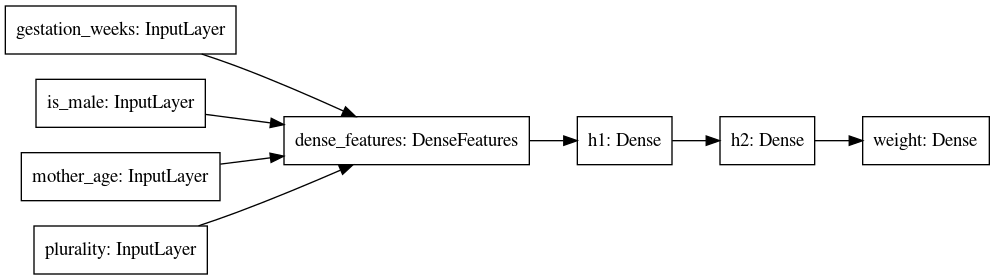

In [47]:
tf.keras.utils.plot_model(
    model=model, to_file="dnn_model.png", show_shapes=False, rankdir="LR")

## モデルを実行して評価する

### トレーニングと評価。

CSVファイルからの入力と設計したアーキテクチャを使用してKerasモデルを構築しました。モデルパラメータをトレーニングし、定期的に評価を実行して、トレーニングが進むにつれて外部データでどの程度うまく機能しているかを追跡することで、モデルを実行してみましょう。 trainデータセットとevalデータセットの両方をロードし、fitメソッドを介してそれらをモデルに送信する必要があります。データをロードするときは、正しいパターン、バッチサイズ、およびモードがあることを確認してください。

In [52]:
# TODO 5
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5  # トレーニングデータセットが繰り返され、ラップアラウンドします
NUM_EVALS = 5  # 評価する回数
# 妥当なサンプルを取得するのに十分ですが、速度が低下するほどではありません
NUM_EVAL_EXAMPLES = 10000

trainds = load_dataset(
    pattern="train*",
    batch_size=TRAIN_BATCH_SIZE,
    mode='train')

evalds = load_dataset(
    pattern="eval*",
    batch_size=1000,
    mode='eval').take(count=NUM_EVAL_EXAMPLES // 1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

logdir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, histogram_freq=1)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback])

2021-11-27 02:04:39.481101: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


Epoch 1/5
  1/312 [..............................] - ETA: 0s - loss: 64.0429 - rmse: 8.0027 - mse: 64.0429WARNING:tensorflow:From /opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 19/312 [>.............................] - ETA: 2s - loss: 22.5721 - rmse: 4.2443 - mse: 22.5721

2021-11-27 02:04:41.251254: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2021-11-27 02:04:41.314363: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/20211127-020439/train/plugins/profile/2021_11_27_02_04_41
2021-11-27 02:04:41.316387: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/20211127-020439/train/plugins/profile/2021_11_27_02_04_41/tensorflow-2-3-20211127-095133.trace.json.gz
2021-11-27 02:04:41.332397: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/20211127-020439/train/plugins/profile/2021_11_27_02_04_41
2021-11-27 02:04:41.333129: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to logs/20211127-020439/train/plugins/profile/2021_11_27_02_04_41/tensorflow-2-3-20211127-095133.memory_profile.json.gz
2021-11-27 02:04:41.334330: I tensorflow/python/pr

312/312 [==============================] - 3s 9ms/step - loss: 2.5698 - rmse: 1.3032 - mse: 2.5698 - val_loss: 1.1929 - val_rmse: 1.0919 - val_mse: 1.1929
Epoch 2/5
312/312 [==============================] - 3s 8ms/step - loss: 1.1984 - rmse: 1.0814 - mse: 1.1984 - val_loss: 1.1620 - val_rmse: 1.0779 - val_mse: 1.1620
Epoch 3/5
312/312 [==============================] - 2s 6ms/step - loss: 1.1728 - rmse: 1.0734 - mse: 1.1728 - val_loss: 1.1695 - val_rmse: 1.0812 - val_mse: 1.1695
Epoch 4/5
312/312 [==============================] - 2s 7ms/step - loss: 1.1586 - rmse: 1.0656 - mse: 1.1586 - val_loss: 1.1995 - val_rmse: 1.0951 - val_mse: 1.1995
Epoch 5/5
312/312 [==============================] - 2s 8ms/step - loss: 1.1701 - rmse: 1.0709 - mse: 1.1701 - val_loss: 1.1183 - val_rmse: 1.0571 - val_mse: 1.1183


### 損失曲線を視覚化する

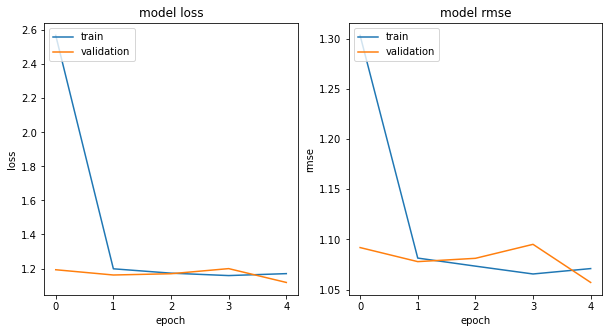

In [53]:
# Plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(["loss", "rmse"]):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history["val_{}".format(key)])
    plt.title("model {}".format(key))
    plt.ylabel(key)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left");

### モデルを保存します

In [56]:
OUTPUT_DIR = "babyweight_trained"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(
    OUTPUT_DIR, datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
tf.saved_model.save(
    obj=model, export_dir=EXPORT_PATH)  # デフォルトのサービング機能付き
print("Exported trained model to {}".format(EXPORT_PATH))

INFO:tensorflow:Assets written to: babyweight_trained/20211127020653/assets
Exported trained model to babyweight_trained/20211127020653


In [55]:
!ls $EXPORT_PATH

assets	saved_model.pb	variables


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License